In [2]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Assignment #5 - University of Memphis. Fall 2021
# Question #2, Convolutional Variational Auto-Encoder (VAE)
# Last updated - Nov 23, 2021 
# https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10/notebook

In [16]:
#####################################################################################
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.datasets import cifar10
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os

%matplotlib inline

In [9]:
#####################################################################################
# Path

path = 'C:/Users/CIRL/Desktop/Bereket/Neural Networks/Assignment 5/document_denoising_dataset'

# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))
test_cleaned_img = sorted(os.listdir(path + '/test_cleaned'))

In [10]:
size = 32
channel = 3

In [17]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
dir_to_scan = "C:/Users/CIRL/Desktop/Bereket/Neural Networks/Assignment 5/document_denoising_dataset"
BATCH_SIZE = 32
IMG_HEIGHT = 420
IMG_WIDTH = 540

In [29]:
train_generator = tf.keras.utils.image_dataset_from_directory(directory=dir_to_scan+"/train",
                                                     batch_size=BATCH_SIZE,
                                                     #shuffle=True,
                                                     color_mode='grayscale',    
                                                   )

Found 144 files belonging to 1 classes.


In [30]:
train_cleaned_generator =  tf.keras.utils.image_dataset_from_directory(directory=dir_to_scan+"/train_cleaned",
                                                     batch_size=BATCH_SIZE,
                                                     #shuffle=True,
                                                     color_mode='grayscale',    
                                                   )

Found 144 files belonging to 1 classes.


In [23]:
test_generator = valid_datagen.flow_from_directory(directory=dir_to_scan+"/test",
                                                     batch_size=BATCH_SIZE,
                                                     #shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     color_mode='grayscale',    
                                                     class_mode='input')

Found 72 images belonging to 1 classes.


In [25]:
test_cleaned_generator = valid_datagen.flow_from_directory(directory=dir_to_scan+"/test_cleaned",
                                                     batch_size=BATCH_SIZE,
                                                     #shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     color_mode='grayscale',    
                                                     class_mode='input')

Found 76 images belonging to 1 classes.


In [11]:
#####################################################################################
# Build Encoder 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

#####################################################################################
# Build Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
#autoencoder.summary()

In [31]:
#####################################################################################
# Train the network

epochs = 25
batch_size = 256

history = autoencoder.fit(train_generator,
                train_cleaned_generator,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_img, test_cleaned_img)
               )

ValueError: `y` argument is not supported when using dataset as input.

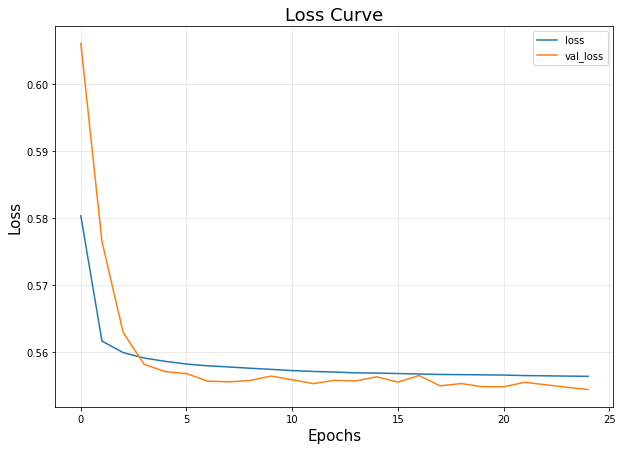

In [8]:
#####################################################################################
# Plot loss function

# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

In [9]:
#####################################################################################
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, cifar_test_noise.shape[0]-48) 

cifar_test_images = cifar_test_noise[rand:rand+num_imgs] # slicing
cifar_test_desoided = autoencoder.predict(cifar_test_images) # predict

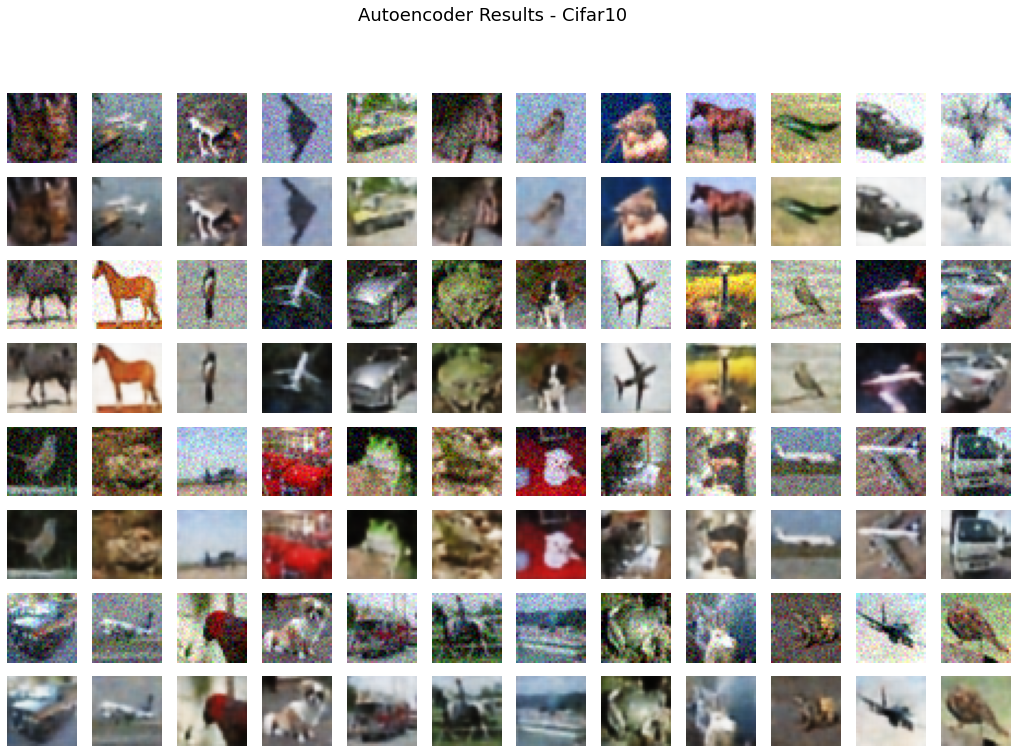

In [10]:
#####################################################################################
# Visualize test images with their denoised images

rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_desoided[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()